In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

In [21]:
image_dir = Path('../input/20-dog-breed-data/tr_images')

In [22]:
image_dir

PosixPath('../input/20-dog-breed-data/tr_images')

In [23]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

In [24]:
[os.path.abspath(filepaths[0]) for filepaths[0] in filepaths ]

['/kaggle/input/20-dog-breed-data/tr_images/tr_images/Beagle/n02088364_17167.jpg',
 '/kaggle/input/20-dog-breed-data/tr_images/tr_images/Beagle/n02088364_7247.jpg',
 '/kaggle/input/20-dog-breed-data/tr_images/tr_images/Beagle/n02088364_12710.jpg',
 '/kaggle/input/20-dog-breed-data/tr_images/tr_images/Beagle/n02088364_16519.jpg',
 '/kaggle/input/20-dog-breed-data/tr_images/tr_images/Beagle/n02088364_12102.jpg',
 '/kaggle/input/20-dog-breed-data/tr_images/tr_images/Beagle/n02088364_2840.jpg',
 '/kaggle/input/20-dog-breed-data/tr_images/tr_images/Beagle/n02088364_6547.jpg',
 '/kaggle/input/20-dog-breed-data/tr_images/tr_images/Beagle/n02088364_5572.jpg',
 '/kaggle/input/20-dog-breed-data/tr_images/tr_images/Beagle/n02088364_12124.jpg',
 '/kaggle/input/20-dog-breed-data/tr_images/tr_images/Beagle/n02088364_11391.jpg',
 '/kaggle/input/20-dog-breed-data/tr_images/tr_images/Beagle/n02088364_4070.jpg',
 '/kaggle/input/20-dog-breed-data/tr_images/tr_images/Beagle/n02088364_12794.jpg',
 '/kaggle

In [25]:
images.Label.value_counts()

Pomeranian             219
Shih-Tzu               214
Afghan_hound           203
Pug                    200
Beagle                 195
Siberian_husky         192
Japanese_spaniel       185
Labrador_retriever     171
Saint_Bernard          170
African_hunting_dog    169
Great_Dane             156
German_shepherd        152
Chihuahua              152
Tibetan_mastiff        152
Rottweiler             152
Toy_poodle             151
Doberman               150
Golden_retriever       150
Bulldog                101
Dalmation               64
Name: Label, dtype: int64

In [26]:
images

Filepath          Label
0     ../input/20-dog-breed-data/tr_images/tr_images...         Beagle
1     ../input/20-dog-breed-data/tr_images/tr_images...         Beagle
2     ../input/20-dog-breed-data/tr_images/tr_images...         Beagle
3     ../input/20-dog-breed-data/tr_images/tr_images...         Beagle
4     ../input/20-dog-breed-data/tr_images/tr_images...         Beagle
...                                                 ...            ...
3293  ../input/20-dog-breed-data/tr_images/tr_images...  Saint_Bernard
3294  ../input/20-dog-breed-data/tr_images/tr_images...  Saint_Bernard
3295  ../input/20-dog-breed-data/tr_images/tr_images...  Saint_Bernard
3296  ../input/20-dog-breed-data/tr_images/tr_images...  Saint_Bernard
3297  ../input/20-dog-breed-data/tr_images/tr_images...  Saint_Bernard

[3298 rows x 2 columns]

In [27]:
train_df, test_df = train_test_split(images, train_size=0.7, shuffle=True, random_state=1)

In [28]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [29]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1847 validated image filenames belonging to 20 classes.
Found 461 validated image filenames belonging to 20 classes.
Found 990 validated image filenames belonging to 20 classes.


In [30]:
pretrained_model = tf.keras.applications.resnet50.ResNet50(
                    input_shape=(224, 224, 3),
                    include_top=False,
                    weights='imagenet',
                    pooling='avg')

pretrained_model.trainable = False

In [31]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(50, activation='relu')(x)
outputs = tf.keras.layers.Dense(20, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [32]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [33]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
history = model.fit(train_images,validation_data=val_images,epochs=25,
    callbacks=[callbacks])

Epoch 1/25
58/58 [==============================] - 19s 281ms/step - loss: 1.3119 - accuracy: 0.6622 - val_loss: 0.4871 - val_accuracy: 0.8547
Epoch 2/25
58/58 [==============================] - 11s 196ms/step - loss: 0.2267 - accuracy: 0.9339 - val_loss: 0.3669 - val_accuracy: 0.8959
Epoch 3/25
58/58 [==============================] - 12s 204ms/step - loss: 0.0935 - accuracy: 0.9756 - val_loss: 0.2765 - val_accuracy: 0.9132
Epoch 4/25
58/58 [==============================] - 12s 199ms/step - loss: 0.0391 - accuracy: 0.9940 - val_loss: 0.2599 - val_accuracy: 0.9176
Epoch 5/25
58/58 [==============================] - 12s 207ms/step - loss: 0.0163 - accuracy: 0.9995 - val_loss: 0.2342 - val_accuracy: 0.9284
Epoch 6/25
58/58 [==============================] - 12s 201ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.2372 - val_accuracy: 0.9328
Epoch 7/25
58/58 [==============================] - 12s 208ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.2356 - val_accuracy: 0.9328

In [34]:
results = model.evaluate(test_images, verbose=0)
print(results)
print(f"Test Accuracy: {np.round(results[1] * 100,2)}%")

[0.24467501044273376, 0.9282828569412231]
Test Accuracy: 92.83%


In [35]:
predictions = np.argmax(model.predict(test_images), axis=1)
matrix = confusion_matrix(test_images.labels, predictions)
report= classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

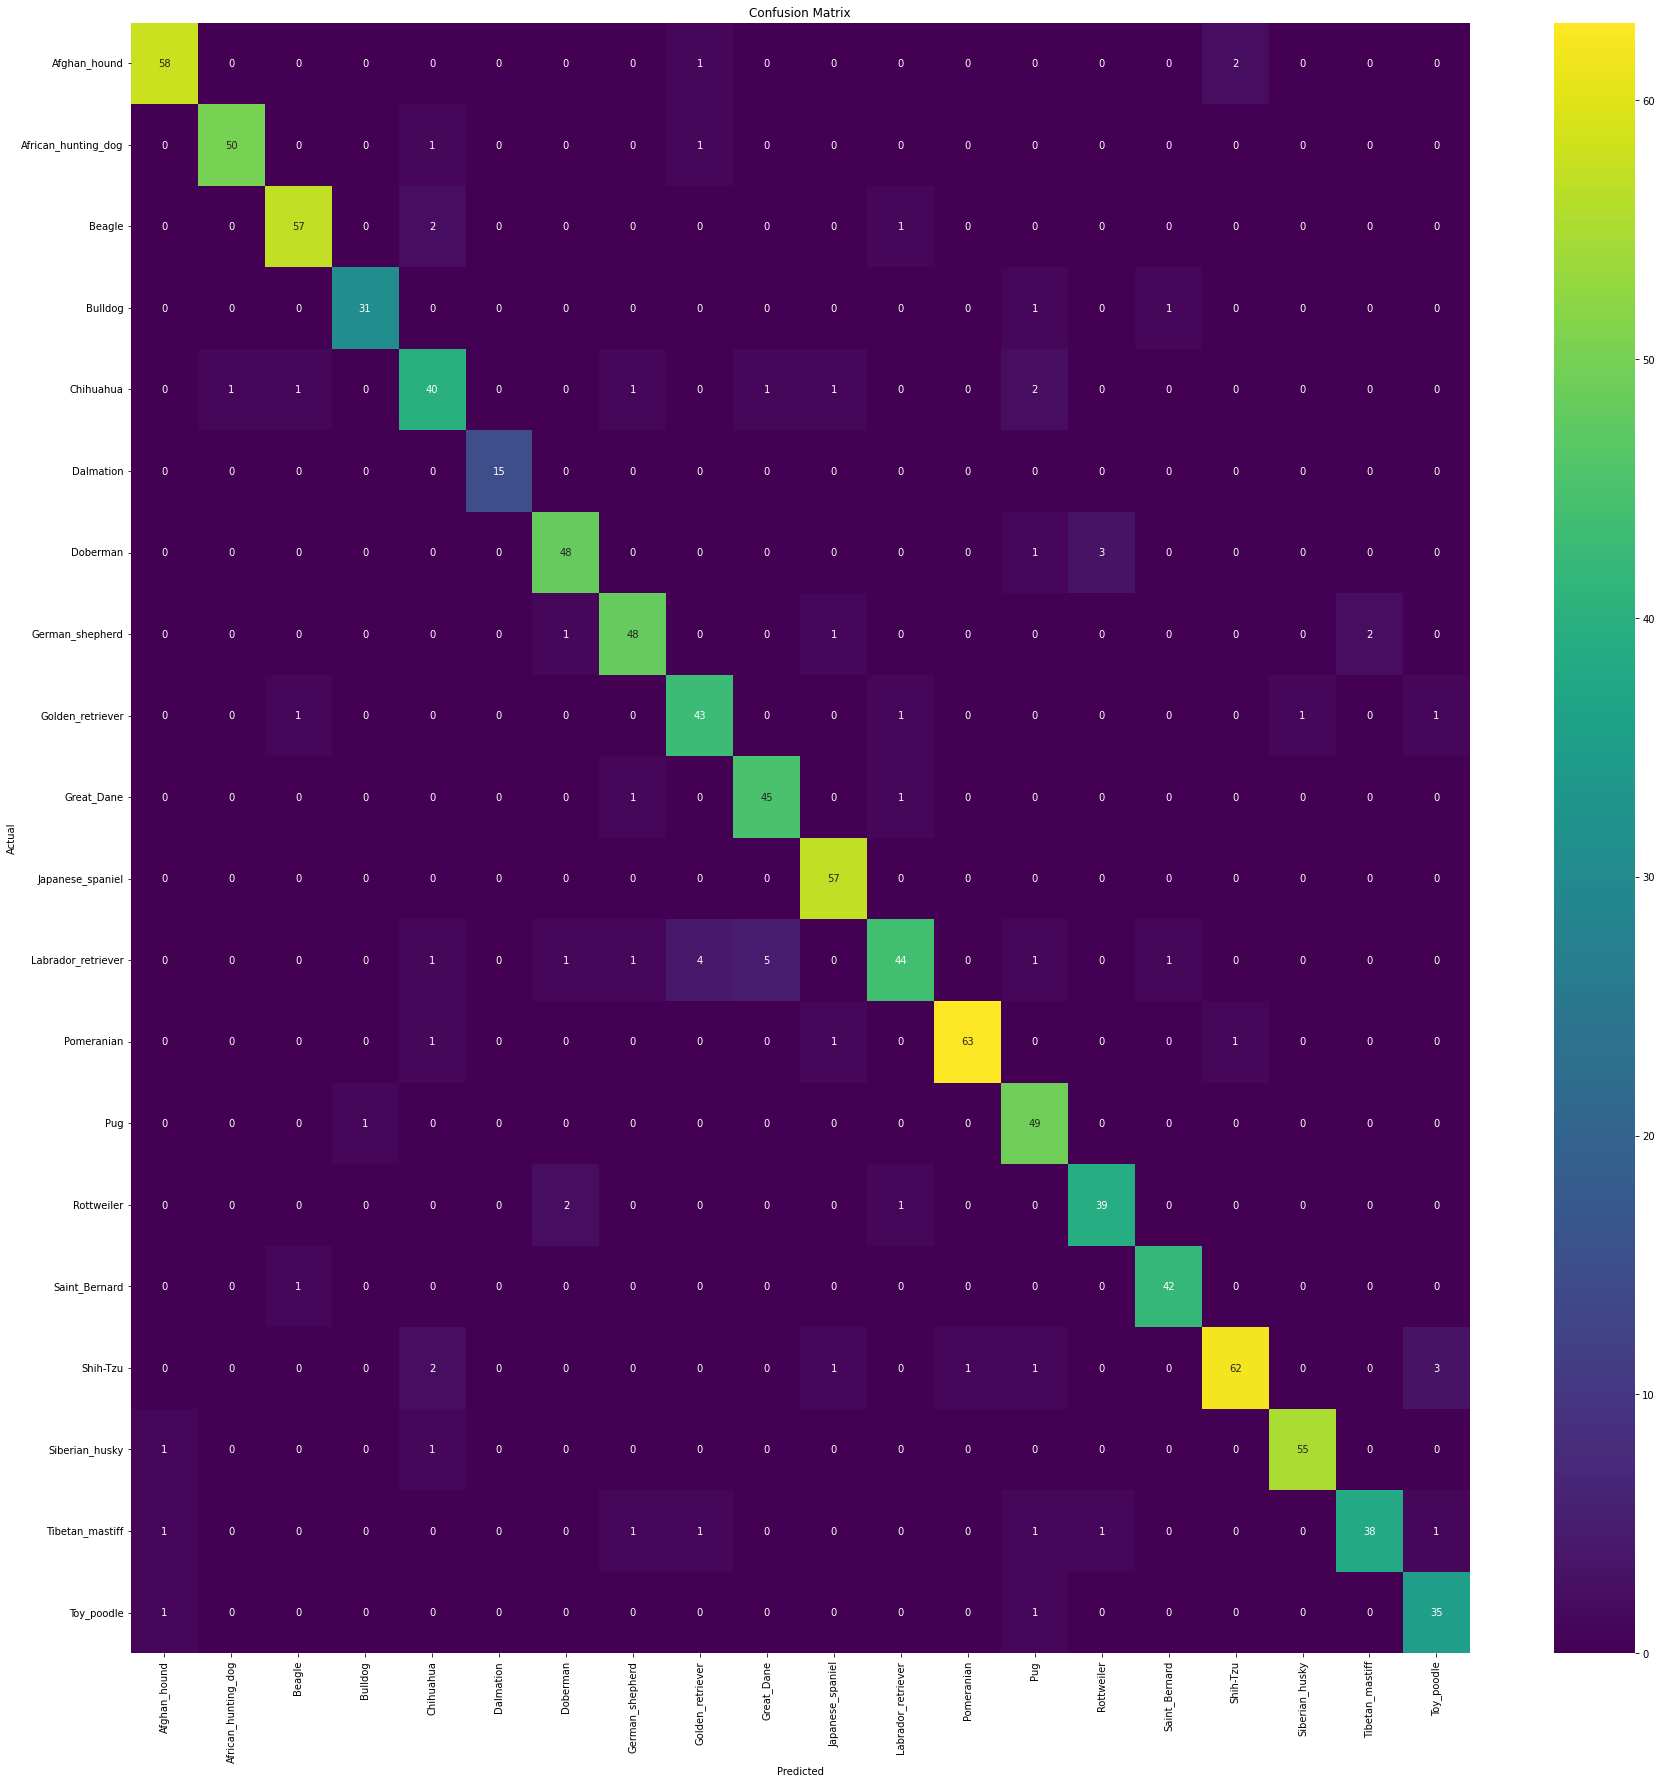

In [36]:
fig = plt.figure(figsize=(30, 30))
sns.heatmap(matrix, annot=True, cmap='viridis')
plt.xticks(ticks=np.arange(20) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(20) + 0.5, labels=test_images.class_indices, rotation=0)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
fig.savefig("Confusion Matrix",dpi=700)

In [37]:
print("Classification Report:\n", report)

Classification Report:
                      precision    recall  f1-score   support

       Afghan_hound       0.95      0.95      0.95        61
African_hunting_dog       0.98      0.96      0.97        52
             Beagle       0.95      0.95      0.95        60
            Bulldog       0.97      0.94      0.95        33
          Chihuahua       0.83      0.85      0.84        47
          Dalmation       1.00      1.00      1.00        15
           Doberman       0.92      0.92      0.92        52
    German_shepherd       0.92      0.92      0.92        52
   Golden_retriever       0.86      0.91      0.89        47
         Great_Dane       0.88      0.96      0.92        47
   Japanese_spaniel       0.93      1.00      0.97        57
 Labrador_retriever       0.92      0.76      0.83        58
         Pomeranian       0.98      0.95      0.97        66
                Pug       0.86      0.98      0.92        50
         Rottweiler       0.91      0.93      0.92        42

In [38]:
data_his = pd.DataFrame(history.history)
data_his

loss  accuracy  val_loss  val_accuracy
0  1.311900  0.662155  0.487148      0.854664
1  0.226706  0.933947  0.366856      0.895879
2  0.093528  0.975636  0.276458      0.913232
3  0.039078  0.994044  0.259862      0.917570
4  0.016327  0.999459  0.234234      0.928416
5  0.010438  1.000000  0.237180      0.932755
6  0.006308  1.000000  0.235564      0.932755
7  0.004656  1.000000  0.240708      0.924078

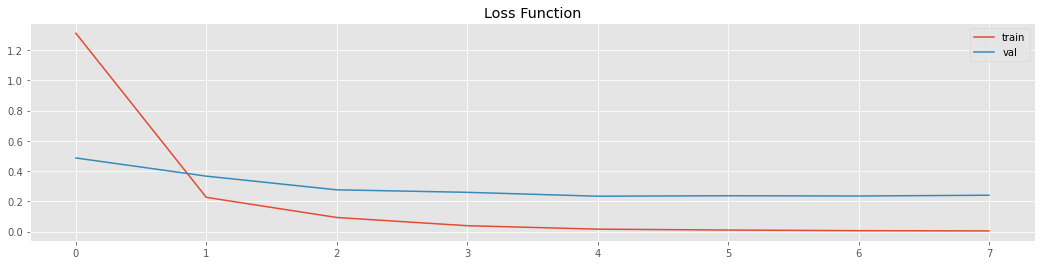

In [39]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(18, 4))
plt.plot(data_his['loss'], label = 'train')
plt.plot(data_his['val_loss'], label = 'val')
plt.legend()
plt.title('Loss Function')
plt.show()
fig.savefig("Loss Function",dpi=700)

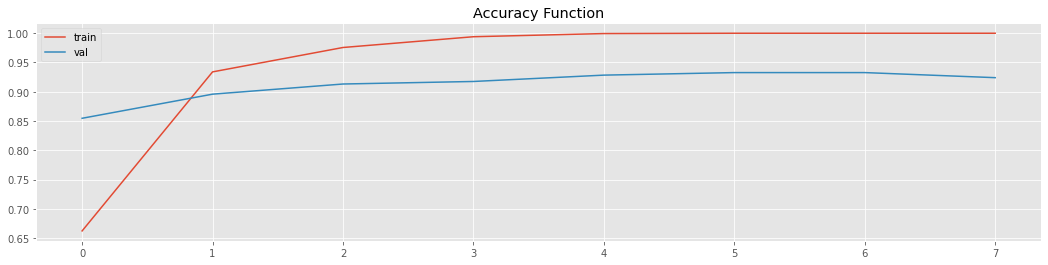

In [40]:
fig = plt.figure(figsize=(18, 4))
plt.plot(data_his['accuracy'], label = 'train')
plt.plot(data_his['val_accuracy'], label = 'val')
plt.legend()
plt.title('Accuracy Function')
plt.show()
fig.savefig("Accuracy Function",dpi=700)

In [41]:
train_images.class_indices.keys()

dict_keys(['Afghan_hound', 'African_hunting_dog', 'Beagle', 'Bulldog', 'Chihuahua', 'Dalmation', 'Doberman', 'German_shepherd', 'Golden_retriever', 'Great_Dane', 'Japanese_spaniel', 'Labrador_retriever', 'Pomeranian', 'Pug', 'Rottweiler', 'Saint_Bernard', 'Shih-Tzu', 'Siberian_husky', 'Tibetan_mastiff', 'Toy_poodle'])

In [42]:
train_images.class_indices.values()

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [43]:
df=pd.DataFrame({'names':list(train_images.class_indices.keys()),
                 'index':list(train_images.class_indices.values())})

In [44]:
df.iloc[0]['names']

'Afghan_hound'

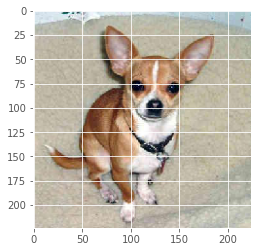

4    Chihuahua
Name: names, dtype: object


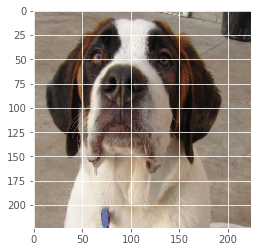

15    Saint_Bernard
Name: names, dtype: object


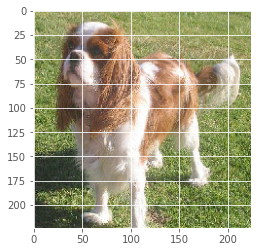

16    Shih-Tzu
Name: names, dtype: object


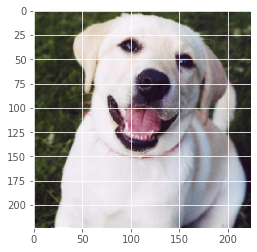

11    Labrador_retriever
Name: names, dtype: object


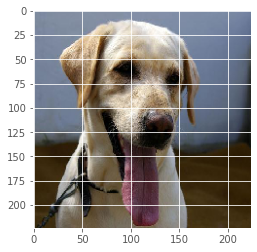

11    Labrador_retriever
Name: names, dtype: object


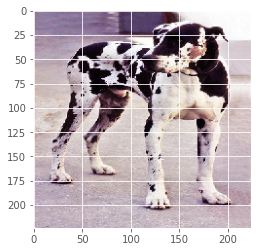

9    Great_Dane
Name: names, dtype: object


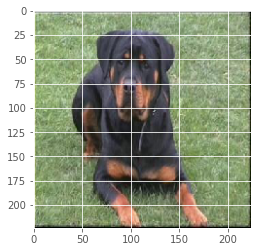

2    Beagle
Name: names, dtype: object


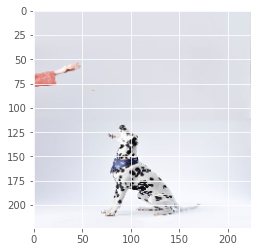

5    Dalmation
Name: names, dtype: object


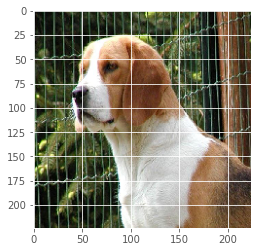

2    Beagle
Name: names, dtype: object


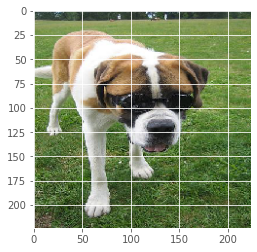

3    Bulldog
Name: names, dtype: object


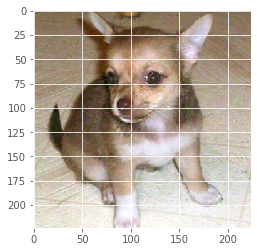

4    Chihuahua
Name: names, dtype: object


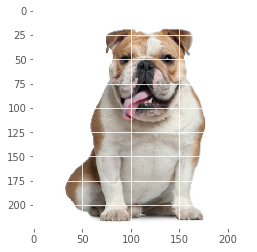

3    Bulldog
Name: names, dtype: object


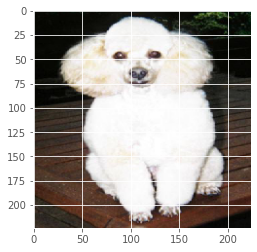

19    Toy_poodle
Name: names, dtype: object


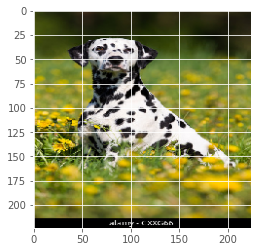

5    Dalmation
Name: names, dtype: object


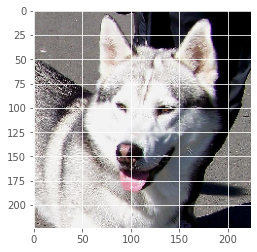

17    Siberian_husky
Name: names, dtype: object


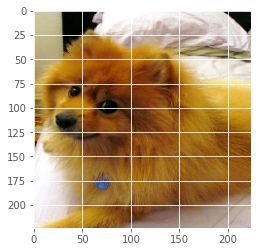

12    Pomeranian
Name: names, dtype: object


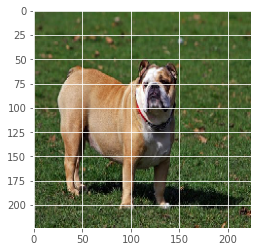

3    Bulldog
Name: names, dtype: object


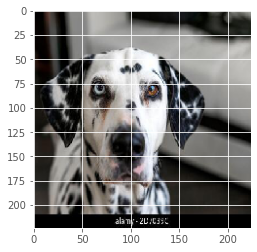

5    Dalmation
Name: names, dtype: object


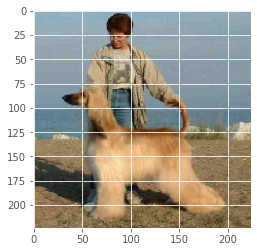

0    Afghan_hound
Name: names, dtype: object


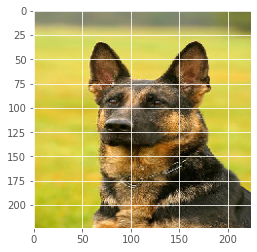

4    Chihuahua
Name: names, dtype: object


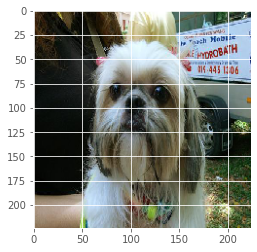

16    Shih-Tzu
Name: names, dtype: object


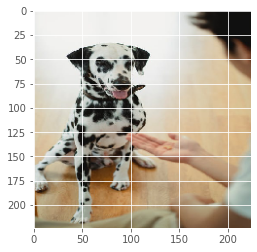

5    Dalmation
Name: names, dtype: object


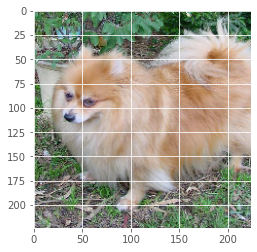

12    Pomeranian
Name: names, dtype: object


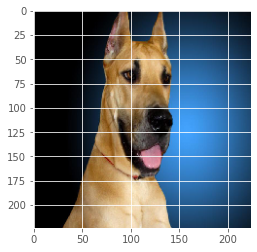

6    Doberman
Name: names, dtype: object


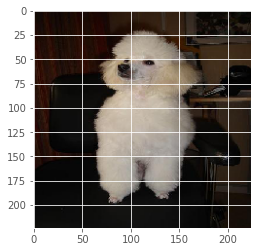

19    Toy_poodle
Name: names, dtype: object


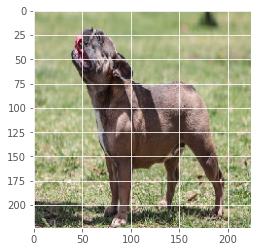

13    Pug
Name: names, dtype: object


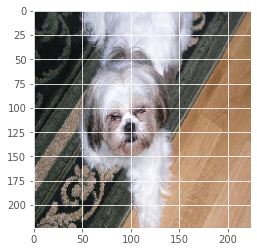

16    Shih-Tzu
Name: names, dtype: object


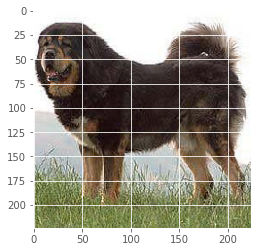

18    Tibetan_mastiff
Name: names, dtype: object


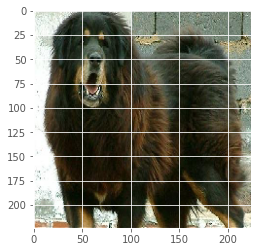

18    Tibetan_mastiff
Name: names, dtype: object


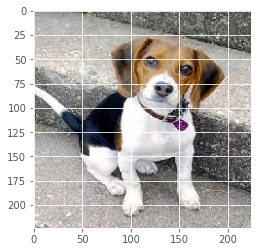

2    Beagle
Name: names, dtype: object


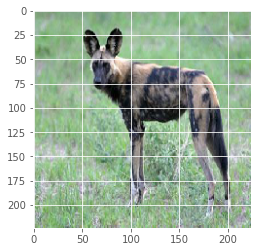

1    African_hunting_dog
Name: names, dtype: object


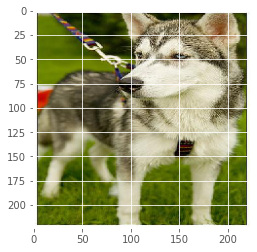

17    Siberian_husky
Name: names, dtype: object


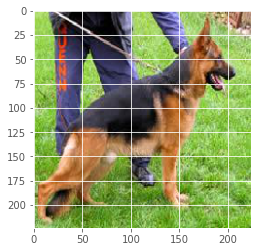

17    Siberian_husky
Name: names, dtype: object


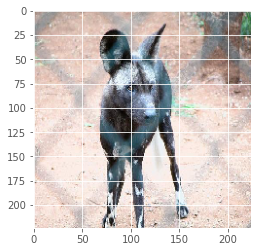

1    African_hunting_dog
Name: names, dtype: object


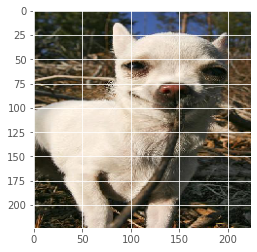

4    Chihuahua
Name: names, dtype: object


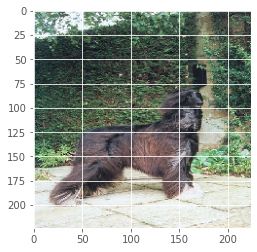

0    Afghan_hound
Name: names, dtype: object


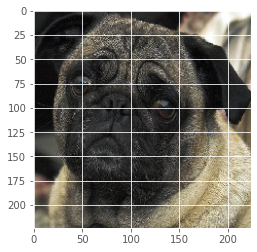

13    Pug
Name: names, dtype: object


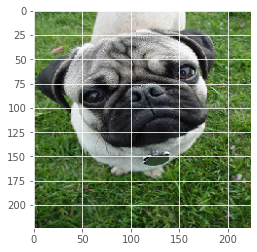

13    Pug
Name: names, dtype: object


In [46]:
from tensorflow.keras.preprocessing import image
dir_path = '../input/20-dog-breed-data/test/test'

for i in os.listdir(dir_path):
    img = image.load_img(dir_path+'/'+i,target_size=(224,224))
    plt.imshow(img)
    plt.show()
    
    X = image.img_to_array(img)
    X = np.expand_dims(X,axis=0)
    images = np.vstack([X])
    predictions = np.argmax(model.predict(images), axis=1)
    print(df.iloc[predictions]['names'])

In [47]:
model.save("dogmodel.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
